# LAMPADA Hg

https://atomic-spectra.net/spectrum.php?sw=550&lw=700&elem=Hg

__QUESTA PARTE E' INVALIDATA DA TUTTO QUELLO CHE VIENE DOPO, TRASCURABILE__

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import os
import sys
from jax import grad
from jax import numpy as jnp

dir_path = os.path.abspath('')
sys.path.append(dir_path + '/../')

from giopy import Interpolazione, final_val

dir_path = os.path.abspath('')
FILE = dir_path + '/data/' + 'prisma.csv'
fr = pd.read_csv(FILE)
fr = fr.sort_values('RIFLESSA deg')

In [2]:
# START,,RIFLESSA deg,RIFLESSA prim,GIALLO deg,GIALLO prim,VERDE deg,VERDE prim,BLU deg,BLU prim,VIOLA deg,VIOLA prim

ang_incidente = np.array(fr['RIFLESSA deg'] + 0.01*fr['RIFLESSA prim']/6 - 90)* 0.5 # * np.pi/180
giallo = np.array(90 - fr['GIALLO deg'] + 0.01*fr['GIALLO prim']/6) # * np.pi/180
verde = np.array(90 - fr['VERDE deg'] + 0.01*fr['VERDE prim']/6) # * np.pi/180
blu = np.array(90 - fr['BLU deg'] + 0.01*fr['BLU prim']/6) # * np.pi/180
viola = np.array(90 - fr['VIOLA deg'] + 0.01*fr['VIOLA prim']/6) # * np.pi/180

sigmaY = 0.5 * np.ones_like(giallo) # * np.pi/180
sigmaX = 0.5 * np.ones_like(ang_incidente) # * np.pi/180

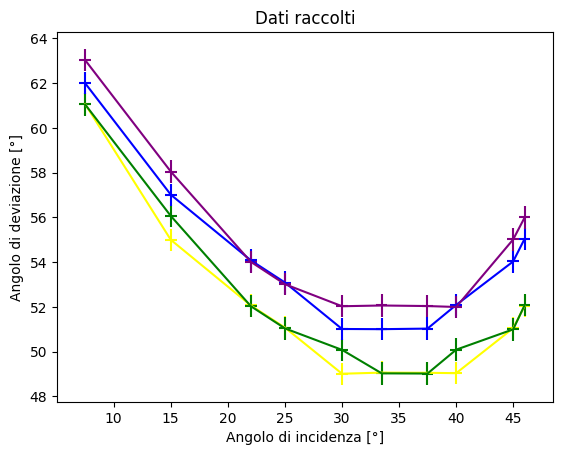

In [3]:
plt.title('Dati raccolti')
plt.errorbar(ang_incidente,giallo,yerr=sigmaY,xerr=sigmaX,color='yellow')
plt.errorbar(ang_incidente,verde,yerr=sigmaY,xerr=sigmaX,color='green')
plt.errorbar(ang_incidente,blu,yerr=sigmaY,xerr=sigmaX,color='blue')
plt.errorbar(ang_incidente,viola,yerr=sigmaY,xerr=sigmaX,color='purple')
plt.xlabel('Angolo di incidenza [°]')
plt.ylabel('Angolo di deviazione [°]')

plt.show()


I dati sopra rappresentati mettono in evidenza la presenza di un angolo di minima deviazione

non serve a niente

### ANGOLO MINIMA DEVIAZIONE (FIT PARABOLICO)

Ricaviamo il valore dell'angolo di minima deviazione interpolando con una parabola gli angoli di deviazione



In [4]:
def parabola(x, a, b, θ):
    return a*(x - θ)**2 + b

fit_giallo = Interpolazione(ang_incidente, giallo,sigmaY,sigmaX, parabola, [0.1, 50, 35],names=['a','b','θ'])
fit_verde = Interpolazione(ang_incidente, verde,sigmaY,sigmaX, parabola, [0.1, 50, 35],names=['a','b','θ'])
fit_blu = Interpolazione(ang_incidente, blu,sigmaY,sigmaX, parabola, [0.1, 50, 35],names=['a','b','θ'])
fit_viola = Interpolazione(ang_incidente, viola,sigmaY,sigmaX, parabola, [0.1, 50, 35],names=['a','b','θ'])

fit = np.array([fit_giallo,fit_verde,fit_blu,fit_viola])

In [5]:
δm = np.array([f.values['θ'] for f in fit]) # indici di rifrazione
sigmaδm = np.array([f.errors['θ'] for f in fit])

n = np.sin((δm + 60)/2 * np.pi/180) / np.sin(30*np.pi/180)

# λ_Hg = np.array([435.8, 404.7,546.1, 576.9]) # nm


Sopra sono esplicitati gli angoli di minima deviazione partendo da dei fit parabolici

I dati utilizzati sono quelli raccolti in data 23 maggio.
Meglio non prendere in considerazione questi set in quanto i dati non sono efficienti per la stima delle grandezze da ricavare

(PARTE DA NON METTERE NELLA RELAZIONE)

------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------- 


# MISURAZIONE DIRETTA ANGOLO DI MINIMA DEVIAZIONE

misurazioni fatte in data 24 maggio (OK DA METTERE NELLA RELAZIONE)

1. ponendo il prisma sulla piattaforma e lampada ad Hg sono stati raccolti i valori degli angoli di minima deviazione $\delta_m$ per le righe dello spettro

#### CONSIDERAZIONI QUALITATIVE sulle linee osservate:
 - Rosso: poco visibile
 - Giallo: molto visibile
 - Verde: molto visibile
 - Acqua: abbastanza visibile (doppia)
 - Blu: molto visibile
 - Viola: raccolti i dati di due tonalità di viola ma poco visibili

I viola non sono stati considerati nelle misurazioni in quanto poco visibili 

$\sin{(\frac{\delta_m + \alpha}{2})} = n \cdot \sin\frac{\alpha}{2}$

$n(\lambda) = a + \frac{b}{\lambda^2}$

In [6]:
FILE = dir_path + '/data/' + 'prismaHg.csv'
fr = pd.read_csv(FILE)

α,sigmaα = np.float64(60.18),np.float64(0.35) # calcolati in angolo_alpha
errore_lettura = 0.044 # deg calcolato in errori

# ROSSO deg ,ROSSO prim,GIALLO deg,GIALLO prim,VERDE deg,VERDE prim,ACQUA deg,ACQUA prim,BLU deg,BLU prim,VIOLA2 deg,VIOLA2 prim,VIOLA 1 deg,VIOLA 1 prim

rosso = np.array(fr['ROSSO deg'] + 0.1 * fr['ROSSO prim']/6)
verde = np.array(fr['VERDE deg'] + 0.1 * fr['VERDE prim']/6)
blu = np.array(fr['BLU deg'] + 0.1 * fr['BLU prim']/6)
viola1 = np.array(fr['VIOLA 1 deg'] + 0.1 * fr['VIOLA 1 prim']/6)
viola2 = np.array(fr['VIOLA2 deg'] + 0.1 * fr['VIOLA2 prim']/6)
acqua = np.array(fr['ACQUA deg'] + 0.1 * fr['ACQUA prim']/6)
giallo = np.array(fr['GIALLO deg'] + 0.1 * fr['GIALLO prim']/6)

rossom, sigmarosso = np.mean(rosso), np.std(rosso, ddof=1)
verdem, sigmaverde = np.mean(verde), np.std(verde, ddof=1)
blum, sigmablu = np.mean(blu), np.std(blu, ddof=1)
viola1m, sigmaviola1 = np.mean(viola1), np.std(viola1, ddof=1)
viola2m, sigmaviola2 = np.mean(viola2), np.std(viola2, ddof=1)
acquam, sigmaacqua = np.mean(acqua), np.std(acqua, ddof=1)
giallom, sigmagiallo = np.mean(giallo), np.std(giallo, ddof=1)

FILE = dir_path + '/data/' + 'LINEE_SPETTRO_Hg.csv'
fr = pd.read_csv(FILE)
fr.set_index('colore',inplace=True)
fr = fr.sort_values('λ (nm)',ascending=False)

# ESCLUDO I VIOLA IN QUANTO DIFFICILMENTE VISIBLI

λ_Hg = np.array(fr['λ (nm)'])#[:-1] # * (10**-9) # nm
sigmaλ_Hg = np.array(fr['sigmaλ'])#[:-1] # * (10**-9)
δm = 360 - np.array([rossom,giallom,verdem,acquam,blum,viola2m,viola1m]) # ,viola1m,viola2m])
sigmaδm = np.sqrt((np.array([sigmarosso,sigmagiallo,sigmaverde,sigmaacqua,sigmablu,sigmaviola2,sigmaviola1])/3)**2 + errore_lettura**2) # sommo in quadratura con valore trovato in errori 

print('λ (Hg) [nm]: ',λ_Hg)
print('sigmaλ (Hg) [nm]: ',sigmaλ_Hg)
print('Angolo minima deviazione [deg]: ',δm)
print('sigmaδm [deg]: ',sigmaδm)

λ (Hg) [nm]:  [615 579 546 491 436 405 392]
sigmaλ (Hg) [nm]:  [1 1 1 1 1 1 1]
Angolo minima deviazione [deg]:  [48.05555556 48.33333333 48.77777778 49.38888889 50.47222222 51.31111111
 51.76111111]
sigmaδm [deg]:  [0.05445004 0.044      0.07778963 0.05445004 0.04683163 0.0458324
 0.12285942]


----------------- VALORI FIT: -----------------
a: (9.193 ± 0.006)e-1 
b: (5.459 ± 0.138)e3 

dof: 5
chi2: 1.25
chi2 ridotto: 0.25
pvalue: 0.94
------------------------------------------------



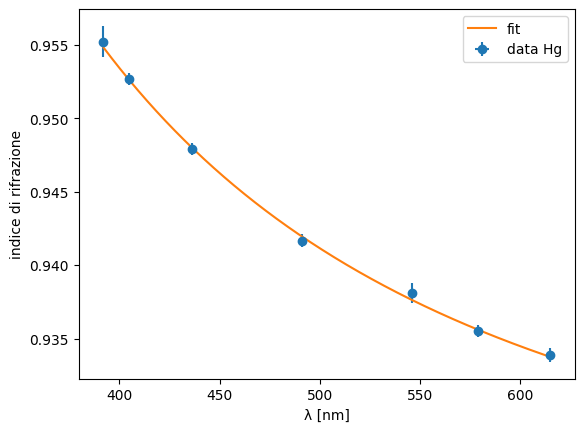

In [7]:
def indice_rifrazione(δm): # α = 60.18, δm = angolo minima deviazione
    return jnp.sin((δm + α)/2 * jnp.pi/180) / jnp.sin(α*jnp.pi/180)

def sigma_indice_rifrazione(δm,sigmaδm):
    didn = np.array([grad(indice_rifrazione)(i) for i in n])
    return jnp.abs(didn * sigmaδm)

α,sigmaα = 60.18, 0.35 # sigma alpha viene trascurato a piè pari
n = indice_rifrazione(δm)
sigman = sigma_indice_rifrazione(δm,sigmaδm)


######################## stima parametri a , b ############################

def indice_rifrazione_lambda(λ,a,b):
    return a + b/(λ**2)

fit = Interpolazione(λ_Hg, n, sigman, sigmaλ_Hg, indice_rifrazione_lambda, [0.921, 5400	], names=['a','b'])
print(fit)
# print(fit.covariance)

plt.errorbar(fit.X,fit.Y,yerr=fit.sigmaY,xerr=fit.sigmaX,fmt='o',label='data Hg')
plt.xlabel('λ [nm]')
plt.ylabel('indice di rifrazione')
plt.plot(*fit.draw(),label='fit')
plt.legend()
plt.show()

# GAS IGNOTO CON PRISMA:

$\lambda = \sqrt{\frac{b}{n - a}} $

δm [51.25       50.41666667 49.33333333 48.33333333 48.66666667]
n:  [0.95234381 0.94759697 0.94135121 0.93551119 0.9374658 ]
λ [nm]:  [406.54 439.34 497.71 580.53 548.39] ± [10.6  12.95 18.14 27.98 23.79] nm


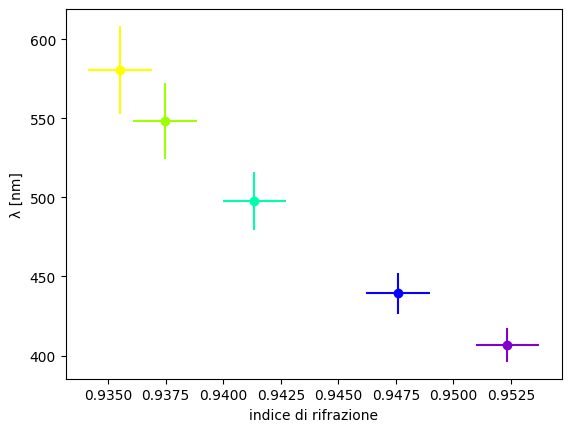

In [8]:
FILE = dir_path + '/data/' + 'prisma_gas_incognito.csv'

fr = pd.read_csv(FILE)
fr.set_index('colore',inplace=True)
fr = fr.sort_values('DEG')

δm = 360 - np.array(fr['DEG'] + 0.1 * fr['PRIM']/6)
sigmaδm = np.ones_like(δm) * 0.159 # proveniente da errori

n = indice_rifrazione(δm) # funzione definita sopra
sigman = sigma_indice_rifrazione(δm,sigmaδm) # funzione definita sopra

def lambda_from_indice_rifrazione(n,a = fit.values['a'],b = fit.values['b']):
    return jnp.sqrt(b/(n - a))

def sigma_indice_rifrazione_lambda(n,sigman,sigmaa,sigmab,a = fit.values['a'],b = fit.values['b'],sigmaab = fit.covariance[0][1]):
    dda = np.array([grad(lambda_from_indice_rifrazione, argnums=1)(i,a,b) for i in n])
    ddb = np.array([grad(lambda_from_indice_rifrazione, argnums=2)(i,a,b) for i in n])
    ddn = np.array([grad(lambda_from_indice_rifrazione, argnums=0)(i,a,b) for i in n])
    return jnp.sqrt((dda * sigmaa)**2 + (ddb * sigmab)**2 + (ddn * sigman)**2) # + 2 * dda * ddn * sigmaa * sigman + 2 * ddb * ddn * sigmab * sigman) # + 2 * dda * ddb * sigmaab)

λ_ignoto = lambda_from_indice_rifrazione(n)
sigmaλ_ignoto = sigma_indice_rifrazione_lambda(n,sigman,fit.errors['a'],fit.errors['b'])

print('δm',δm)
print('n: ',n)
print('λ [nm]: ',final_val(λ_ignoto,sigmaλ_ignoto,2,udm='nm'))

dir_path = os.path.abspath('')
sys.path.append(dir_path + '/')
from spectra_reppresentation import wave2rgb

color = np.array([wave2rgb(l) for l in λ_ignoto])


for i,l,c,sl,sn in zip(n,λ_ignoto,color,sigmaλ_ignoto,sigman):
    plt.errorbar(i,l,yerr=sl,xerr=sn,fmt='o',color=c)
    
plt.xlabel('indice di rifrazione')
plt.ylabel('λ [nm]')
plt.show()



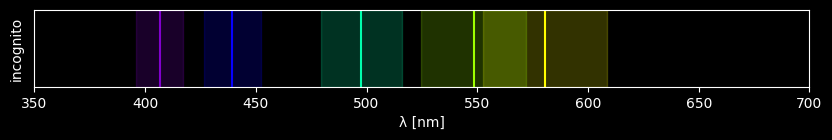

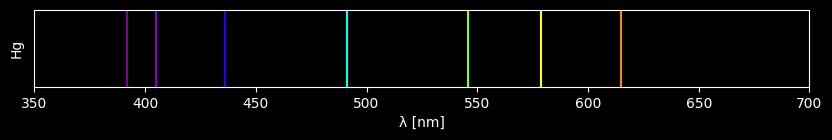

In [9]:
dir_path = os.path.abspath('')
sys.path.append(dir_path + '/')
from spectra_reppresentation import draw_spectrum

draw_spectrum(λ_ignoto,sigmaλ_ignoto,ytitle='incognito')
draw_spectrum(λ_Hg,ytitle='Hg')

In [10]:
# QUANTIFICAZIONE COMPATIBILITA':
from scipy.stats import chi2 as chi2f
λ_Hg =  np.sort(λ_Hg[1:-1]) # ocio che ricompilando taglia ulteriormente e da errore, bisogna fare restart
chi2 = np.sum(((λ_Hg - λ_ignoto)/sigmaλ_ignoto)**2)
df = len(λ_Hg) - 2
pvalue = np.round(chi2f.sf(chi2,df),3)

print('chi2: ',np.round(chi2,3))
print('df: ',df)
print('rchi2: ',np.round(chi2/df,2))
print('pvalue: ',pvalue)


chi2:  3.404
df:  3
rchi2:  1.1300000000000001
pvalue:  0.333


sopra lo spettro del gas ignoto sotto quello dell'Hg

I due spettri sono compatibili fra loro

__NOTA__: è probabile che le tonalità di viola osservate siano poco attendibili (viola1 e viola2). Effettivamente sono presenti righe in quella regione ma poco visibili, potrebbe esserci un bias nella scelta dei valori di $\lambda$